# Лабораторная работа №3
## Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.
## Выполнил: Ли М.В.  Группа: ИУ5-64Б
### Задание:
1.Выберите набор данных (датасет) для решения задачи классификации или регрессии.

2.С использованием метода train_test_split разделите выборку на обучающую и тестовую.

3.Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.

4.Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.

5.Сравните метрики качества исходной и оптимальной моделей.

In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn.datasets import *
from typing import Dict, Tuple
from sklearn.model_selection import train_test_split 
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
import matplotlib.ticker as ticker
import math
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
%matplotlib inline 
sns.set(style="whitegrid")


### Выборка датасета и ее разделение на тестовую и обучающую


In [2]:
breast_cancer = load_breast_cancer()

In [3]:
for x in breast_cancer:
    print(x)

data
target
frame
target_names
DESCR
feature_names
filename


In [4]:
# Сформируем DataFrame
breast_cancer_df = pd.DataFrame(data= np.c_[breast_cancer['data'], breast_cancer['target']],
                     columns= list(breast_cancer['feature_names']) + ['target'])

In [5]:
breast_cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


In [6]:
sc = MinMaxScaler()
breast_cancer_sc = sc.fit_transform(breast_cancer.data)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
breast_cancer_sc, breast_cancer.target, test_size=0.33, random_state=1)

In [8]:
# Размер обучающей выборки
X_train.shape,Y_train.shape

((381, 30), (381,))

In [9]:
# Размер тестовой выборки
X_test.shape, Y_test.shape

((188, 30), (188,))

In [10]:
X_train

array([[0.55274741, 0.25059182, 0.53631401, ..., 0.57525773, 0.26197516,
        0.19362456],
       [0.2607317 , 0.24146094, 0.24462719, ..., 0.0956701 , 0.06938695,
        0.04394595],
       [0.282976  , 0.29015894, 0.27910994, ..., 0.22707904, 0.32367435,
        0.11432507],
       ...,
       [0.48364807, 0.50084545, 0.48655933, ..., 0.65257732, 0.34456929,
        0.51725043],
       [0.3336173 , 0.3902604 , 0.31787713, ..., 0.27364261, 0.13029765,
        0.13859373],
       [0.28628899, 0.29455529, 0.26826066, ..., 0.17226804, 0.08318549,
        0.043618  ]])

In [11]:
Y_train

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,

In [12]:
X_test

array([[0.36485399, 0.14440311, 0.37613157, ..., 0.38075601, 0.24876799,
        0.24294897],
       [0.29291495, 0.30267163, 0.29154861, ..., 0.71752577, 0.46027991,
        0.41230487],
       [0.28250272, 0.21339195, 0.27192316, ..., 0.3628866 , 0.35777646,
        0.26761118],
       ...,
       [0.60717497, 0.42069665, 0.59574321, ..., 0.82061856, 0.23713779,
        0.13846255],
       [0.49642671, 0.50625634, 0.49968903, ..., 0.59140893, 0.1172876 ,
        0.24898334],
       [0.29906763, 0.40108218, 0.28643494, ..., 0.19292096, 0.2113148 ,
        0.07569198]])

###  Обучение модели и оценка ее качества


In [13]:
# 2 ближайших соседа

reg1_1 = KNeighborsClassifier(n_neighbors=2)
reg1_1.fit(X_train,Y_train)
target1_1 = reg1_1.predict(X_test)
len(target1_1), target1_1

(188,
 array([1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]))

In [14]:
accuracy_score(Y_test, target1_1)

0.9574468085106383

In [15]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    classes = np.unique(y_true)
    res = dict()
    for c in classes:
        temp_data_flt = df[df['t']==c]
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [16]:
# 2 ближайших соседа
print_accuracy_score_for_classes(Y_test, target1_1)

Метка 	 Accuracy
0 	 0.9538461538461539
1 	 0.959349593495935


### Кросс-валидация


In [17]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

In [18]:
kf = KFold(n_splits=5)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        breast_cancer_sc, breast_cancer.target, scoring=scoring, 
                        cv=kf, return_train_score=True)
scores

{'fit_time': array([0.00601196, 0.00299382, 0.00311136, 0.00397801, 0.00299215]),
 'score_time': array([0.01454091, 0.0123682 , 0.01199245, 0.0145328 , 0.00716782]),
 'test_precision': array([0.95613188, 0.95010337, 0.96514312, 0.9591089 , 0.93459708]),
 'train_precision': array([0.98734066, 0.97166449, 0.97727737, 0.97332362, 0.97722415]),
 'test_recall': array([0.95614035, 0.94736842, 0.96491228, 0.95614035, 0.92035398]),
 'train_recall': array([0.98681319, 0.96923077, 0.97582418, 0.97142857, 0.97587719]),
 'test_f1': array([0.95605944, 0.94756499, 0.96469636, 0.95682492, 0.92340952]),
 'train_f1': array([0.98688352, 0.96948639, 0.97595915, 0.97156884, 0.9759728 ])}

In [19]:
kf1 = LeaveOneOut()
scores1 = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        breast_cancer_sc,breast_cancer.target, scoring=scoring, 
                        cv=kf1, return_train_score=True)
scores1

C:\Users\enjoy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\enjoy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\enjoy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\enjoy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWar

C:\Users\enjoy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\enjoy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\enjoy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\enjoy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWar

C:\Users\enjoy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\enjoy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.00698423, 0.00178242, 0.00498557, 0.00698113, 0.00401974,
        0.        , 0.01562047, 0.        , 0.00502086, 0.00299239,
        0.00471592, 0.00399327, 0.00402045, 0.00401902, 0.00395322,
        0.00399208, 0.00299072, 0.00398946, 0.00395298, 0.01887274,
        0.00495148, 0.00301766, 0.00395608, 0.        , 0.        ,
        0.        , 0.01562142, 0.        , 0.00302315, 0.00401592,
        0.00299239, 0.        , 0.00499034, 0.00398779, 0.00299239,
        0.01558852, 0.00335646, 0.00501466, 0.00398636, 0.00404143,
        0.00398922, 0.00396013, 0.00398755, 0.00398779, 0.00299096,
        0.00398684, 0.00398922, 0.00299239, 0.0039947 , 0.01196647,
        0.00498652, 0.00398874, 0.00598192, 0.00498366, 0.00498867,
        0.00598288, 0.00499034, 0.00547457, 0.00598001, 0.00598216,
        0.00598478, 0.01137161, 0.        , 0.        , 0.        ,
        0.        , 0.00498557, 0.002249  , 0.00399685, 0.00398827,
        0.        , 0.        , 0.  

### Оптимизация гиперпараметров


In [20]:
n_range = np.array(range(1,70,2))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters


[{'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
         35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
         69])}]

In [21]:
#GridSearch
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=kf1, scoring='accuracy')
clf_gs.fit(X_train, Y_train)

GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69])}],
             scoring='accuracy')

In [22]:
clf_gs.cv_results_

{'mean_fit_time': array([0.0018117 , 0.00174626, 0.00199766, 0.00215117, 0.00241277,
        0.00246673, 0.00208115, 0.00353876, 0.00243144, 0.00281325,
        0.00261019, 0.00202312, 0.0023389 , 0.00200821, 0.00172697,
        0.00193674, 0.00192714, 0.00163552, 0.00190436, 0.00240536,
        0.00243987, 0.00209576, 0.00216749, 0.0023078 , 0.0019885 ,
        0.00225676, 0.00217317, 0.00139405, 0.00230241, 0.00180394,
        0.00218051, 0.0025425 , 0.00233556, 0.0017407 , 0.00225984]),
 'std_fit_time': array([0.00046011, 0.00050877, 0.00047894, 0.00053819, 0.00066837,
        0.00259145, 0.00255815, 0.00148311, 0.00445789, 0.00535073,
        0.00529592, 0.00517541, 0.004428  , 0.00366948, 0.00398377,
        0.00501181, 0.00513734, 0.00473014, 0.00477785, 0.0032469 ,
        0.00449573, 0.00438595, 0.00535557, 0.00443389, 0.00479774,
        0.00544717, 0.00540622, 0.00445354, 0.00324098, 0.0048279 ,
        0.00385968, 0.00465127, 0.00552328, 0.00424601, 0.00294394]),
 'mean_scor

In [23]:

# Лучшее значение метрики
clf_gs.best_score_

0.973753280839895

In [24]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=15)

In [25]:

# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 15}

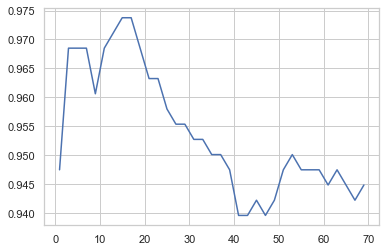

In [26]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

In [27]:
#RandomizedSearchCV
clf_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=kf1, scoring='accuracy')
clf_rs.fit(X_train, Y_train)

RandomizedSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69])}],
                   scoring='accuracy')

In [28]:
# Лучшее значение параметров
clf_rs.best_params_

{'n_neighbors': 15}

In [29]:
# Лучшая модель
clf_rs.best_estimator_

KNeighborsClassifier(n_neighbors=15)

### K-fold

In [30]:
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=kf, scoring='accuracy')
clf_gs.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69])}],
             scoring='accuracy')

In [31]:
clf_gs.best_score_, clf_gs.best_params_

(0.9659945317840055, {'n_neighbors': 3})

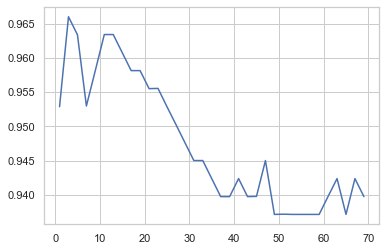

In [32]:

# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

In [33]:
clf_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=kf, scoring='accuracy')
clf_rs.fit(X_train, Y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69])}],
                   scoring='accuracy')

In [34]:
clf_rs.best_score_, clf_rs.best_params_

(0.9659945317840055, {'n_neighbors': 3})